In [1]:
import os
import pandas as pd
import numpy as np
import math

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import multilabel_confusion_matrix

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

###### List of files in the project directory for future reference

In [2]:
os.listdir()

['.DS_Store',
 '.git',
 '.github',
 '.ipynb_checkpoints',
 'Books_ratings_R_version',
 'books_rating_project_EDA_3.ipynb',
 'books_rating_project_EDA_Cleaning_1.ipynb',
 'books_rating_project_EDA_Cleaning_2.ipynb',
 'data',
 'Project_Description_ML_2023.docx.pdf',
 'Python_labs_project.ipynb',
 'README.md',
 'requirements.txt']

###### Data is kept seprate from the main project folder. Listing the data files that are available

In [3]:
os.listdir('data')

['books.csv',
 'cleaned_books.csv',
 'uncleaned_books.csv',
 'uncleaned_books.csv_bad_lines.txt',
 'working_books.csv']

###### For this part of the project, we will be working with the cleaned_books.csv (cleaned in earlier notebooks Cleaning 1 and 2. Future suggestions for cleaning will be updated in EDA_cleaning files so that the final working copy will always be cleaned_books.csv

In [5]:
folder = 'data/'
f_ratings = 'cleaned_books.csv'
ratings_path = folder + f_ratings

In [6]:
###### Note to self: potentially use this as a further cleaning file and end with a cleaner 
###### file of actual feature to be used in the model

In [7]:
df_ratings = pd.read_csv(ratings_path)
df_ratings.head()

,bookID,title,authors,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,average_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,4.57
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,4.42
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,4.56
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,4.78


###### Looking at the columns and looking ahead, we can safely guess we can drop the bookID column from consideration as a feature. We might be able to do something interesting with the title, if we were to do some extra nlp processing on the title, but that is beyond the scope of this iteration of the project. We might be able to make use of the author(s). There is currently some debate as to what affect the author of the book will have on the rating. isbn and isbn13 at first glance do not provide any information and will not be used in the current inquiry (as a side note, if we were to take the time to parse the isbn numbers, they actually provide interesting infromation such as the publisher, langauge published in, issuing agengy of the publication code, etc. but, much like the NLP work needed to parse the title, the parsing of isbn codes is beyond the scope of the current project. We might be able to do some work with language, ratings_count and text_reviews count and will be keeping those for the time being. publication date code be an interesting feature, but we would need more information (such as snapshots in time from publication date, whether a book is a reprint of a classic, if a new introduction from another author boosted popularity and therefore perception and sentiment, etc) so we will not be working with publication date during this project. Publisher could have something to do with average rating (again thinking along the lines of how marketing affects percepton of a book, or the cover of a book, etc)


In [15]:
###### Giving a list of the columns as they appear, both as a nice visual, and because sometimes, showing the list will actually
###### show hidden spaces in column names that might cause problems later *** note to self-clean up column names in future
###### iterations of EDA data cleaning
list(df_ratings.columns)

['bookID',
 'title',
 'authors',
 'isbn',
 'isbn13',
 'language_code',
 '  num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'average_rating']

In [16]:
####### Creating a variable to store our working columns. Tried the difference trick used below, but it changed the 
####### ordering of the columns
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'average_rating']

In [17]:
df_ratings_keep = df_ratings[keep_cols]
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78


In [10]:
def round_to_increment_25(number):
    '''Return the string version of the target rounded in .25% increments'''
    rounded_number = round(number / 0.25) * 0.25
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)

In [18]:
def round_to_increment_5(number):
    '''Return the string version of the target rounded in .5% increments'''
    rounded_number = round(number / 0.5) * 0.5
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)
        
#### ***Note to self: consider changing these functions to return as floats, and then use astype to change to strings to more
####    easily switch between log reg problem to classification problem

In [15]:
df_ratings_keep['target_1'] = df_ratings_keep['average_rating'].round(decimals=1)

C:\Users\joesa\AppData\Local\Temp\ipykernel_28060\1862204744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_1'] = df_ratings_keep['average_rating'].round(decimals=1)


In [12]:
df_ratings_keep['target_buckets_25'] = df_ratings_keep['average_rating'].apply(round_to_increment_25)

C:\Users\joesa\AppData\Local\Temp\ipykernel_28060\957174791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_buckets_25'] = df_ratings_keep['average_rating'].apply(round_to_increment_25)


In [13]:
df_ratings_keep['target_buckets_5'] = df_ratings_keep['average_rating'].apply(round_to_increment_5)

C:\Users\joesa\AppData\Local\Temp\ipykernel_28060\2907294488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_buckets_5'] = df_ratings_keep['average_rating'].apply(round_to_increment_5)


In [14]:
df_ratings_keep['target_whole'] = df_ratings_keep['average_rating'].round(decimals=0)

C:\Users\joesa\AppData\Local\Temp\ipykernel_28060\2535471935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratings_keep['target_whole'] = df_ratings_keep['average_rating'].round(decimals=0)


In [16]:
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating,target_buckets_25,target_buckets_5,target_whole,target_1
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57,4.5,4.5,5.0,4.6
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49,4.5,4.5,4.0,4.5
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42,4.5,4.5,4.0,4.4
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56,4.5,4.5,5.0,4.6
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78,4.75,5.0,5.0,4.8


# Testing with .25 buckets

In [35]:
keep_cols = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_buckets_25']

In [36]:
df_ratings_25 = df_ratings_keep[keep_cols]

In [37]:
lbls = df_ratings_25['target_buckets_25'].unique()

In [38]:
df_ratings_25['target_buckets_25'].value_counts(ascending=True)

1.75       1
2.25       1
1.0        2
2.0        6
2.5        7
5.0       24
0         26
2.75      29
4.75      41
3.0       68
3.25     248
4.5      524
3.5     1022
4.25    2336
3.75    2792
4.0     4000
Name: target_buckets_25, dtype: int64

In [39]:
lbls

array(['4.5', '4.75', '3.75', '4.25', '3.5', '4.0', '3.25', '3.0', '0',
       '2.75', '5.0', '2.0', '2.5', '1.0', '1.75', '2.25'], dtype=object)

In [40]:
df_ratings_25_numeric = df_ratings_25[keep_cols]

In [41]:
df_ratings_25_numeric.head()

,num_pages,ratings_count,text_reviews_count,target_buckets_25
0,652,2095690,27591,4.5
1,870,2153167,29221,4.5
2,352,6333,244,4.5
3,435,2339585,36325,4.5
4,2690,41428,164,4.75


In [42]:
y = df_ratings_25_numeric['target_buckets_25']
x = df_ratings_25_numeric[df_ratings_25_numeric.columns.difference(['target_buckets_25'])]

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [44]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [45]:
logreg.fit(x_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0, solver='liblinear')

In [46]:
predictions = logreg.predict(x_test)

In [47]:
score = logreg.score(x_test, y_test)

In [48]:
score

0.3641808924827793

In [49]:
cm = multilabel_confusion_matrix(y_test, predictions)

In [50]:
cm

array([[[3334,    0],
        [   5,    0]],

       [[3338,    0],
        [   1,    0]],

       [[3337,    0],
        [   2,    0]],

       [[3332,    0],
        [   7,    0]],

       [[3319,    0],
        [  20,    0]],

       [[3271,    0],
        [  68,    0]],

       [[3022,    0],
        [ 317,    0]],

       [[2478,    0],
        [ 861,    0]],

       [[  82, 2055],
        [  24, 1178]],

       [[2594,   66],
        [ 642,   37]],

       [[3185,    0],
        [ 154,    0]],

       [[3323,    2],
        [  13,    1]],

       [[3330,    0],
        [   9,    0]]], dtype=int64)

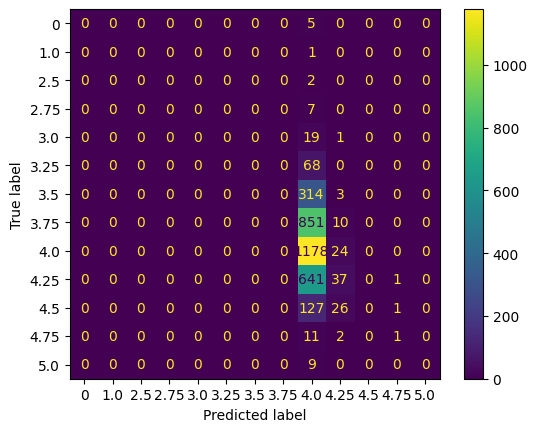

In [51]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)



In [52]:
clf = RandomForestClassifier(n_estimators=100)

In [53]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [54]:
scores

array([0.32092426, 0.33247754, 0.31835687, 0.30892742, 0.32048812])

In [61]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [62]:
predictions = clf.predict(x_test)

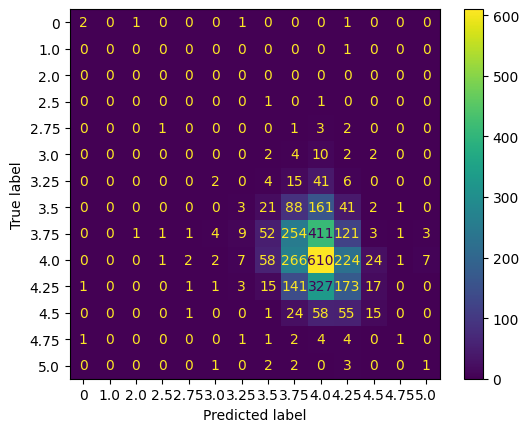

In [65]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


# Testing with .5 buckets

In [ ]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'target_buckets_5']

In [ ]:
df_ratings_5 = df_ratings_keep[keep_cols]

In [ ]:
df_ratings_5_numeric = df_ratings_5[['  num_pages', 'ratings_count', 'text_reviews_count', 'target_buckets_5']]

In [ ]:
df_ratings_5_numeric = df_ratings_5[['ratings_count', 'text_reviews_count', 'target_buckets_5']]

In [ ]:
y = df_ratings_5_numeric['target_buckets_5']
x = df_ratings_5_numeric[df_ratings_5_numeric.columns.difference(['target_buckets_5'])]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
logreg = LogisticRegression(random_state=0, multi_class='ovr', solver = 'liblinear')

In [ ]:
logreg.fit(x_train, y_train)

In [ ]:
predictions = logreg.predict(x_test)

In [ ]:
score = logreg.score(x_test, y_test)

In [ ]:
score

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions)


In [ ]:
clf = RandomForestClassifier(n_estimators=100)

In [ ]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

In [ ]:
scores

# Testing with whole numbers

In [ ]:
keep_cols = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_whole']

In [ ]:
df_ratings_whole = df_ratings_keep[keep_cols]

In [ ]:
y = df_ratings_whole['target_whole']
x = df_ratings_whole[df_ratings_whole.columns.difference(['target_whole'])]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
clf = RandomForestClassifier(n_estimators=100)

In [ ]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)

In [ ]:
scores

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   y_pred)


In [ ]:
clf.feature_importances_

In [ ]:
clf.feature_names_in_

In [ ]:
vectorizer_auth =HashingVectorizer(n_features=1000)

In [ ]:
vectorizer_pub = HashingVectorizer(n_features=1000)

In [ ]:
vectorizer_lang = HashingVectorizer(n_features=1000)

In [ ]:
auths_transform = vectorizer.transform(auths)

In [ ]:
auths_transform_dense = auths_transform.toarray()

In [ ]:
df_ratings_keep.head()

In [ ]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'target_1']

In [ ]:
## keep_cols = ['ratings_count', 'text_reviews_count', 'target_buckets_5']

In [ ]:
df_ratings_5 = df_ratings_keep[keep_cols]

In [ ]:
y = df_ratings_5['target_buckets_5']
x = df_ratings_5[df_ratings_5.columns.difference(['target_buckets_5'])]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [ ]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [ ]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [ ]:
cols = ['ratings_count', 'text_reviews_count']

In [ ]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [ ]:
feats = np.concatenate([auths_train_arr,
                        langs_train_arr, x_train[cols].values], axis = 1)

In [ ]:
feats = np.concatenate([auths_train_arr, x_train[cols].values], axis = 1)

In [ ]:
clf = RandomForestClassifier(n_estimators=100)

In [ ]:
scores = cross_val_score(clf, feats, y_train, cv = 5)

In [ ]:
scores

In [ ]:
scores

In [ ]:
scores

In [ ]:
scores

In [ ]:
scores

In [ ]:
scores

In [ ]:
auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [ ]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [ ]:
clf.fit(train_feats, y_train)

In [ ]:
test_feats = train_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [ ]:
y_pred = clf.predict(test_feats)

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   y_pred)

In [ ]:
clf.feature_importances_

In [ ]:
clf.score(test_feats, y_test)

In [ ]:
?? precision_recall_fscore_support

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

In [ ]:
f1_score

In [ ]:
recall

In [ ]:
precision

In [ ]:
_

In [ ]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'target_1']

In [ ]:
df_ratings_1 = df_ratings_keep[keep_cols]

In [ ]:
y = df_ratings_1['target_1']
x = df_ratings_1[df_ratings_1.columns.difference(['target_1'])]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

In [ ]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [ ]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [ ]:
cols = ['  num_pages', 'ratings_count', 'text_reviews_count']

In [ ]:
train_feats = np.concatenate([auths_train_arr, pubs_train_arr, 
                        langs_train_arr, x_train[cols].values], axis = 1)

In [ ]:
test_feats = train_feats = np.concatenate([auths_test_arr, pubs_test_arr, 
                        langs_test_arr, x_test[cols].values], axis = 1)

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=42)

In [ ]:
reg_sccores = cross_val_score(regr, train_feats, y_train, cv = 5)

In [ ]:
reg_sccores

In [ ]:
y_train = y_train.astype(str)

In [ ]:
y_test = y_test.astype(str)

In [ ]:
clf = RandomForestClassifier(n_estimators=100)

In [ ]:
scores = cross_val_score(clf, train_feats, y_train, cv = 5)

In [ ]:
scores

In [ ]:
clf.fit(train_feats, y_train)

In [ ]:
y_pred = clf.predict(test_feats)

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   y_pred)

In [23]:
keep_cols = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher', 'target_buckets_25']

In [ ]:
#### Experimenting with another bucketing system (terrible, below average, avarage, above avarage, excelent)

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 
        3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0]

df_ratings['average_rating'].plot.hist(bins=bins)

ratings_stats = df_ratings_keep['average_rating'].describe()

ratings_mean = ratings_stats['mean']
ratings_std = ratings_stats['std']

ratings_mean - ratings_std

ratings_mean + ratings_std

df_ratings_keep['target_1'].value_counts()